<a href="https://colab.research.google.com/github/gajanan-nawle/Flipkart-CSAT-GenAI-Azure/blob/main/Capstone_Project_Machine_Learning_%26_GenAI_with_Microsoft_Azure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Phase 1: Setup & Understanding**

# Project 6: Machine Learning & GenAI with Microsoft Azure
## Optimizing Customer Satisfaction (CSAT) for Flipkart

### 1. Business Context
In the highly competitive e-commerce sector, Customer Satisfaction (CSAT) is a primary KPI. Flipkart aims to differentiate itself through superior support. This project analyzes customer support interactions to identify key drivers of satisfaction and predicts CSAT scores to proactively flag at-risk customers.

### 2. Problem Statement
We aim to build a Machine Learning model to predict CSAT scores based on interaction metadata (handling time, channel, agent tenure) and text feedback. Additionally, we will use GenAI to extract root causes from negative feedback to guide agent coaching.

### 3. Project Pipeline
1. **Data Cleaning & EDA:** Handle missing values, outliers, and visualize trends.
2. **Feature Engineering:** Create time-based features and encode categorical variables.
3. **Modeling:** Train classification models (Logistic Regression, Random Forest) handling class imbalance.
4. **GenAI Integration:** Use LLMs to analyze unstructured 'Customer Remarks'.

## **1. Import Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [4]:
# Configuration
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

## **2. Load Dataset**

In [6]:
df = pd.read_csv('Customer_support_data.csv')

## **3. Data Understanding**

In [7]:
#column and row count
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")

Shape: 85907 rows, 20 columns


In [8]:
#Viewing first 5 rows to understand data format
print(df.head())


                              Unique id channel_name         category  \
0  7e9ae164-6a8b-4521-a2d4-58f7c9fff13f      Outcall  Product Queries   
1  b07ec1b0-f376-43b6-86df-ec03da3b2e16      Outcall  Product Queries   
2  200814dd-27c7-4149-ba2b-bd3af3092880      Inbound    Order Related   
3  eb0d3e53-c1ca-42d3-8486-e42c8d622135      Inbound          Returns   
4  ba903143-1e54-406c-b969-46c52f92e5df      Inbound     Cancellation   

                   Sub-category Customer Remarks  \
0                Life Insurance              NaN   
1  Product Specific Information              NaN   
2             Installation/demo              NaN   
3        Reverse Pickup Enquiry              NaN   
4                    Not Needed              NaN   

                               Order_id order_date_time Issue_reported at  \
0  c27c9bb4-fa36-4140-9f1f-21009254ffdb             NaN  01/08/2023 11:13   
1  d406b0c7-ce17-4654-b9de-f08d421254bd             NaN  01/08/2023 12:52   
2  c273368d-b961-

In [9]:
#Checking Data Types and Non-Null counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unique id                85907 non-null  object 
 1   channel_name             85907 non-null  object 
 2   category                 85907 non-null  object 
 3   Sub-category             85907 non-null  object 
 4   Customer Remarks         28742 non-null  object 
 5   Order_id                 67675 non-null  object 
 6   order_date_time          17214 non-null  object 
 7   Issue_reported at        85907 non-null  object 
 8   issue_responded          85907 non-null  object 
 9   Survey_response_Date     85907 non-null  object 
 10  Customer_City            17079 non-null  object 
 11  Product_category         17196 non-null  object 
 12  Item_price               17206 non-null  float64
 13  connected_handling_time  242 non-null    float64
 14  Agent_name            

In [10]:
#Checking for Duplicates
duplicates = df.duplicated(subset=['Unique id']).sum()
print(f"Duplicate Records: {duplicates}")

Duplicate Records: 0


In [11]:
#Statistical Summary of Numerical Columns
print("Numerical Summary")
display(df.describe())

Numerical Summary


,Item_price,connected_handling_time,CSAT Score
count,17206.000000,242.000000,85907.000000
mean,5660.774846,462.400826,4.242157
std,12825.728411,246.295037,1.378903
min,0.000000,0.000000,1.000000
25%,392.000000,293.000000,4.000000
50%,979.000000,427.000000,5.000000
75%,2699.750000,592.250000,5.000000
max,164999.000000,1986.000000,5.000000


In [12]:
#Checking for Class Imbalance (Target Variable)
print("CSAT Score Distribution (Target)")
print(df['CSAT Score'].value_counts(normalize=True) * 100)

CSAT Score Distribution (Target)
CSAT Score
5    69.397139
1    13.072276
4    13.059471
3     2.977639
2     1.493476
Name: proportion, dtype: float64


## **4. Data Cleaning**

In [14]:
# 1. Convert Date Columns to Datetime Objects
# Note the exact column names: 'order_date_time', 'Issue_reported at', etc.
date_cols = ['order_date_time', 'Issue_reported at', 'issue_responded', 'Survey_response_Date']

for col in date_cols:
    # errors='coerce' will handle any weird date formats without crashing
    df[col] = pd.to_datetime(df[col], errors='coerce')

# 2. Handle Missing Values
# Impute 'Item_price' with Median (Note the underscore in 'Item_price')
if 'Item_price' in df.columns:
    price_median = df['Item_price'].median()
    df['Item_price'].fillna(price_median, inplace=True)

# Impute 'Agent Shift' with Mode
if 'Agent Shift' in df.columns:
    shift_mode = df['Agent Shift'].mode()[0]
    df['Agent Shift'].fillna(shift_mode, inplace=True)

# Fill missing 'Customer Remarks'
if 'Customer Remarks' in df.columns:
    df['Customer Remarks'].fillna("No Remarks", inplace=True)

# Drop rows where 'CSAT Score' is missing
df.dropna(subset=['CSAT Score'], inplace=True)

# 3. Verification
print("✅ Dates converted and missing values handled.")
print("\nMissing Values Count After Cleaning:")
print(df.isnull().sum())

✅ Dates converted and missing values handled.

Missing Values Count After Cleaning:
Unique id                      0
channel_name                   0
category                       0
Sub-category                   0
Customer Remarks               0
Order_id                   18232
order_date_time            68693
Issue_reported at          53933
issue_responded            54022
Survey_response_Date           0
Customer_City              68828
Product_category           68711
Item_price                     0
connected_handling_time    85665
Agent_name                     0
Supervisor                     0
Manager                        0
Tenure Bucket                  0
Agent Shift                    0
CSAT Score                     0
dtype: int64


## **5. EDA**

Text(0, 0.5, 'Count')

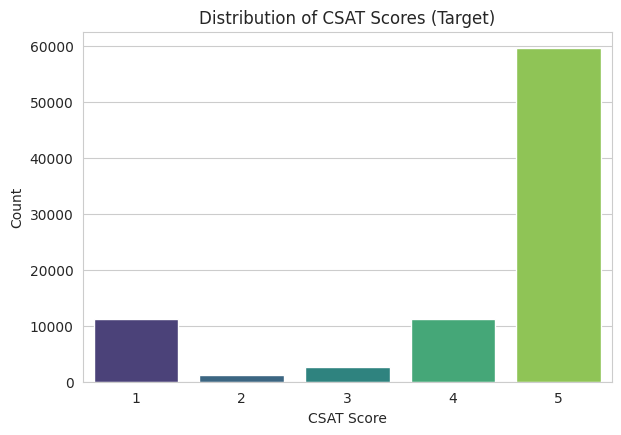

In [17]:
# EXPLORATORY DATA ANALYSIS (EDA)

plt.figure(figsize=(15, 10))

# 1. Target Variable Distribution (CSAT Score)
plt.subplot(2, 2, 1)
sns.countplot(x='CSAT Score', data=df, palette='viridis')
plt.title('Distribution of CSAT Scores (Target)')
plt.xlabel('CSAT Score')
plt.ylabel('Count')



Text(0.5, 0, 'Minutes')

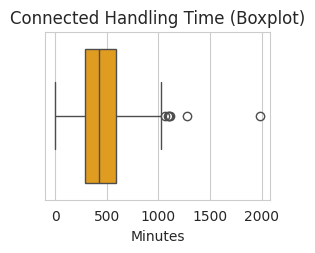

In [19]:
# 2. Handling Time Distribution (Checking for Outliers)
plt.subplot(2, 2, 2)
sns.boxplot(x=df['connected_handling_time'], color='orange')
plt.title('Connected Handling Time (Boxplot)')
plt.xlabel('Minutes')



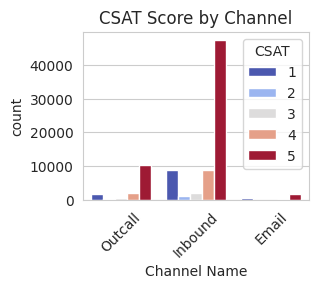

In [21]:
# 3. CSAT by Channel (Bivariate Analysis)
plt.subplot(2, 2, 3)
sns.countplot(x='channel_name', hue='CSAT Score', data=df, palette='coolwarm')
plt.title('CSAT Score by Channel')
plt.xlabel('Channel Name')
plt.xticks(rotation=45)
plt.legend(title='CSAT', loc='upper right')



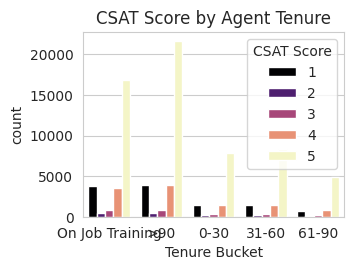

In [27]:
# 4. CSAT by Agent Tenure (Bivariate Analysis)
plt.subplot(2, 2, 4)
# Sorting tenure buckets helps visualization if they are ordinal strings
sns.countplot(x='Tenure Bucket', hue='CSAT Score', data=df, palette='magma')
plt.title('CSAT Score by Agent Tenure')
plt.xlabel('Tenure Bucket')

plt.tight_layout()
plt.show()